In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [6]:
non_country_keywords = [
    "Africa", "Europe", "America", "Asia", "Oceania", "Arab", "World",
    "High income", "Low income", "Middle income", "Euro area", "OECD", "IDA",
    "IBRD", "G7", "G20", "Least developed", "Landlocked", "Small states", "Sub-Saharan",
    "Heavily indebted", "demographic dividend", "middle income", "Other"
]

allowlist = {
    "Egypt, Arab Rep.", "Saudi Arabia", "South Africa",
    "Syrian Arab Republic", "United Arab Emirates", "Central African Republic"
}
def is_region_or_group(name):
    return (
        any(keyword in str(name) for keyword in non_country_keywords)
        and name not in allowlist
    )
def clean_df(df):
    df = df[~df["Country Name"].apply(is_region_or_group)]
    mask = (df.iloc[:, 3:].fillna(0) != 0).any(axis=1)
    df = df[mask].reset_index(drop=True)
    return df

In [ ]:
df_export = pd.read_csv("./data/exports.csv", sep=',', skiprows=4)
df_export = df_export.drop(columns=["Indicator Name", "Indicator Code", "2024", "Unnamed: 69"])
df_export = clean_df(df_export)

df_military = pd.read_csv("./data/military_expenditure.csv", sep=',', skiprows=4)
df_military = df_military.drop(columns=["Indicator Name", "Indicator Code", "2024", "Unnamed: 69"])
df_military = clean_df(df_military)

df_gdp = pd.read_csv("./data/gdp.csv", sep=',', skiprows=4)
df_gdp = df_gdp.drop(columns=["Indicator Name", "Indicator Code", "2024", "Unnamed: 69"])
df_gdp = clean_df(df_gdp)

df_import = pd.read_csv("./data/imports.csv", sep=',', skiprows=4)
df_import = df_import.drop(columns=["Indicator Name", "Indicator Code", "2024", "Unnamed: 69"])
df_import = clean_df(df_import)

In [8]:
from scipy.stats import shapiro

# Überprüfung auf Normalverteilung für alle 4 DataFrames mit dem Shapiro-Wilk-Test

dfs = {'exports': df_export, 'imports': df_import, 'gdp': df_gdp, 'military': df_military}
normalverteilung = {}

for name, df in dfs.items():
	# Werte aller Jahre zusammenfassen (ab Spalte 4)
	vals = df.iloc[:, 4:].values.flatten()
	vals = vals[~np.isnan(vals)]
	# Shapiro-Test (maximal 5000 Werte wegen Limit)
	sample = vals if len(vals) < 5000 else np.random.choice(vals, 5000, replace=False)
	stat, p = shapiro(sample)
	normalverteilung[name] = (stat, p, p > 0.05)

for name, (stat, p, is_normal) in normalverteilung.items():
	print(f"{name}: p={p:.2e} -> {'normalverteilt' if is_normal else 'nicht normalverteilt'}")

print("\nInterpretation:")
print("Da alle Datensätze nicht normalverteilt sind (p < 0.05), ist Spearman-Korrelation geeigneter als Pearson.")
print("Spearman misst monotone Zusammenhänge und ist robust gegenüber Ausreißern und Nicht-Normalverteilung,")
print("während Pearson nur für normalverteilte Daten und lineare Zusammenhänge sinnvoll ist.")

exports: p=1.85e-87 -> nicht normalverteilt
imports: p=2.06e-88 -> nicht normalverteilt
gdp: p=7.60e-91 -> nicht normalverteilt
military: p=1.99e-92 -> nicht normalverteilt

Interpretation:
Da alle Datensätze nicht normalverteilt sind (p < 0.05), ist Spearman-Korrelation geeigneter als Pearson.
Spearman misst monotone Zusammenhänge und ist robust gegenüber Ausreißern und Nicht-Normalverteilung,
während Pearson nur für normalverteilte Daten und lineare Zusammenhänge sinnvoll ist.


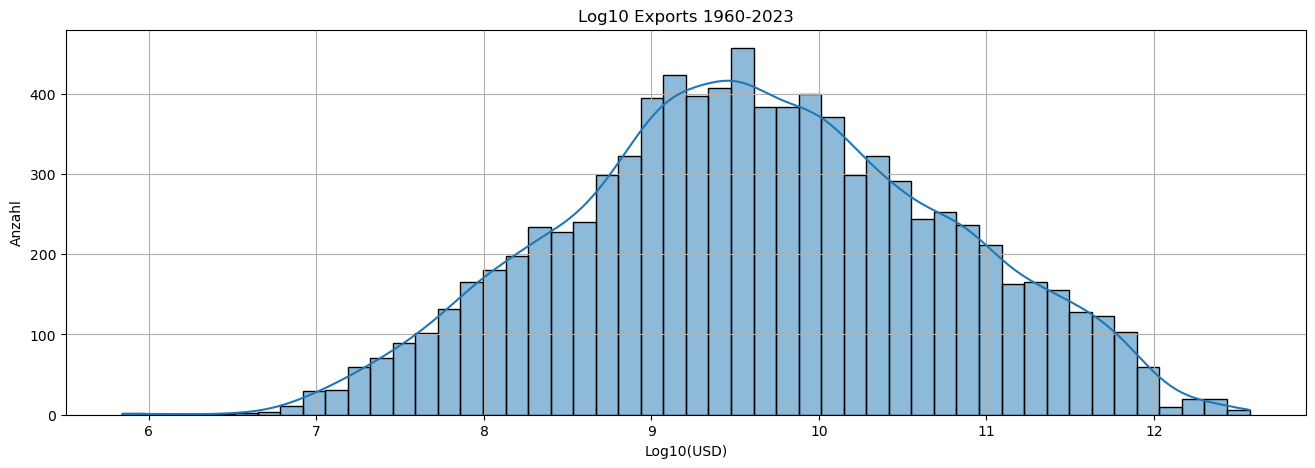

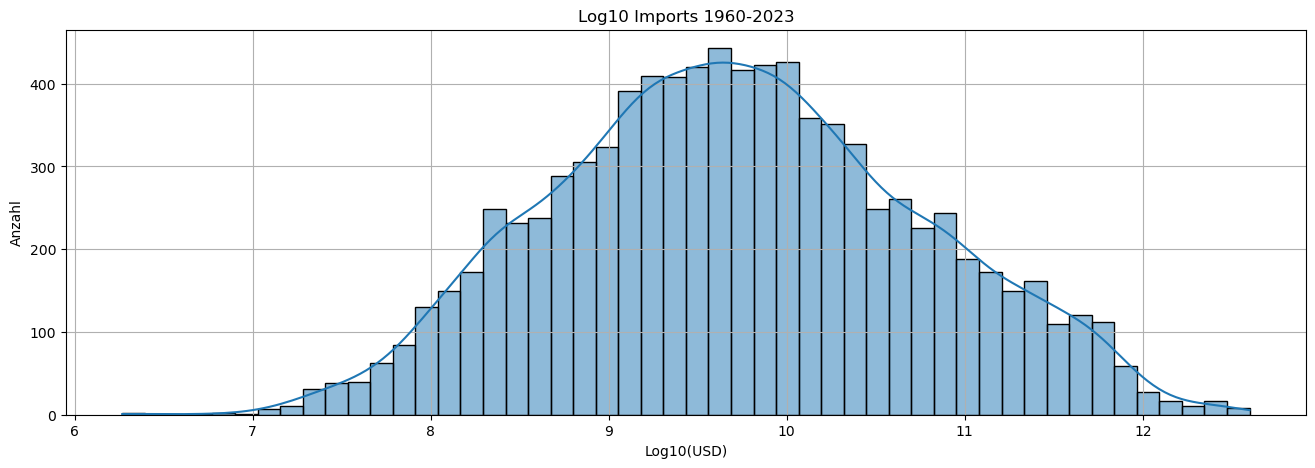

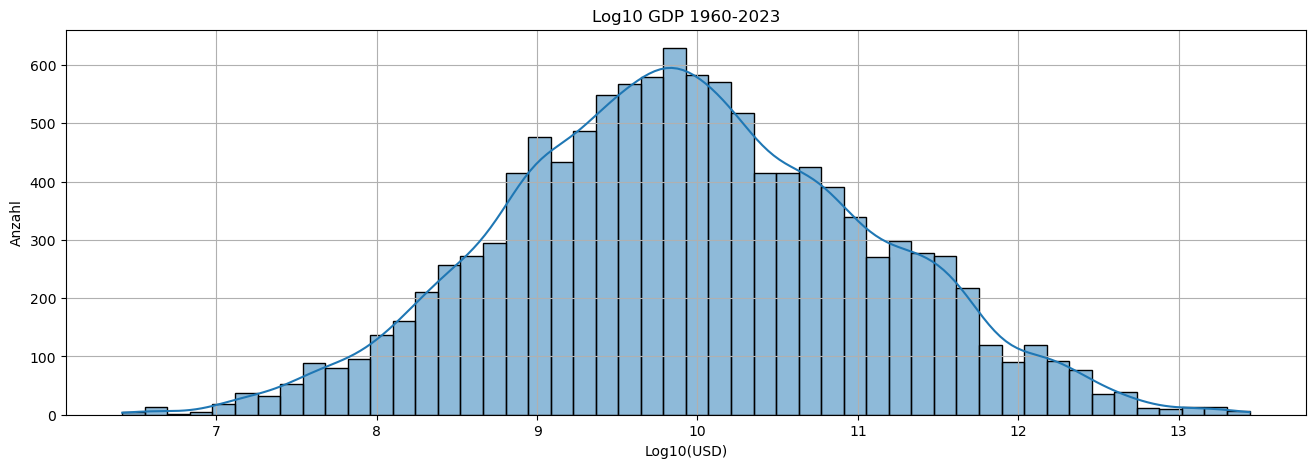

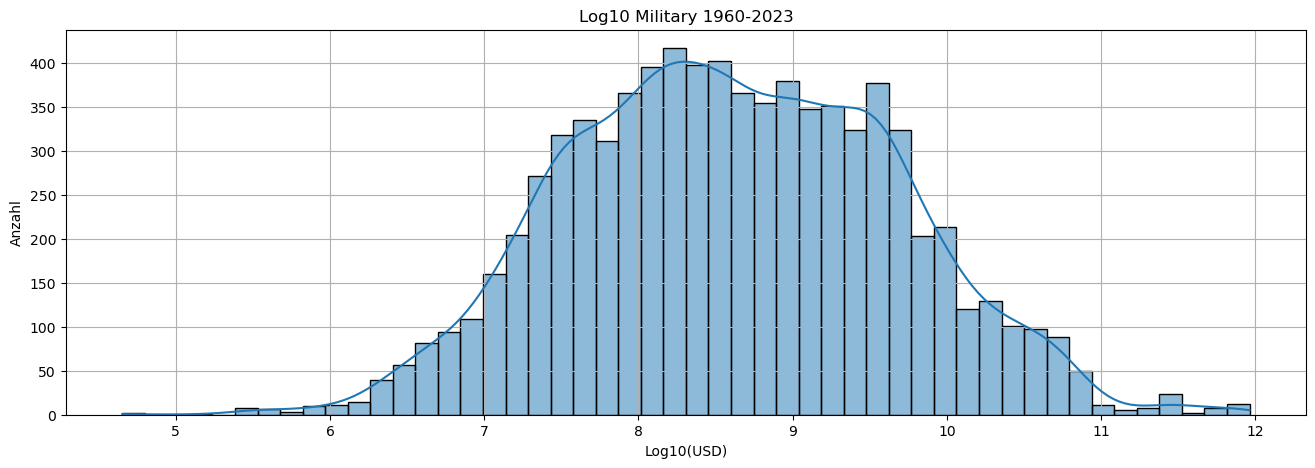

In [9]:
# Visualisierung der (log10-transformierten) Verteilungen für alle 4 DataFrames für alle Jahre 1960-2023

dfs = {
	"Exports": df_export,
	"Imports": df_import,
	"GDP": df_gdp,
	"Military": df_military
}

years = [str(y) for y in range(1960, 2024)]

for name, df in dfs.items():
	plt.figure(figsize=(16, 5))
	log_vals = []
	for year in years:
		if year in df.columns:
			vals = pd.to_numeric(df[year], errors="coerce").dropna()
			vals = vals[vals > 0]
			log_vals.append(np.log10(vals))
	# Kombiniere alle Jahre in ein großes Array für ein Gesamtbild
	all_log_vals = pd.concat(log_vals)
	sns.histplot(all_log_vals, kde=True, bins=50)
	plt.title(f"Log10 {name} 1960-2023")
	plt.xlabel("Log10(USD)")
	plt.ylabel("Anzahl")
	plt.grid(True)
	plt.show()

In [10]:
def find_outliers_z(df, threshold=3):
	outliers = {}
	years = df.columns[4:]
	for year in years:
		vals = df[year]
		mean = vals.mean()
		std = vals.std()
		z_scores = (vals - mean) / std
		outliers[year] = list(vals.index[np.abs(z_scores) > threshold])
	return outliers

outliers_exports_z = find_outliers_z(df_export)
outliers_imports_z = find_outliers_z(df_import)
outliers_gdp_z = find_outliers_z(df_gdp)
outliers_military_z = find_outliers_z(df_military)

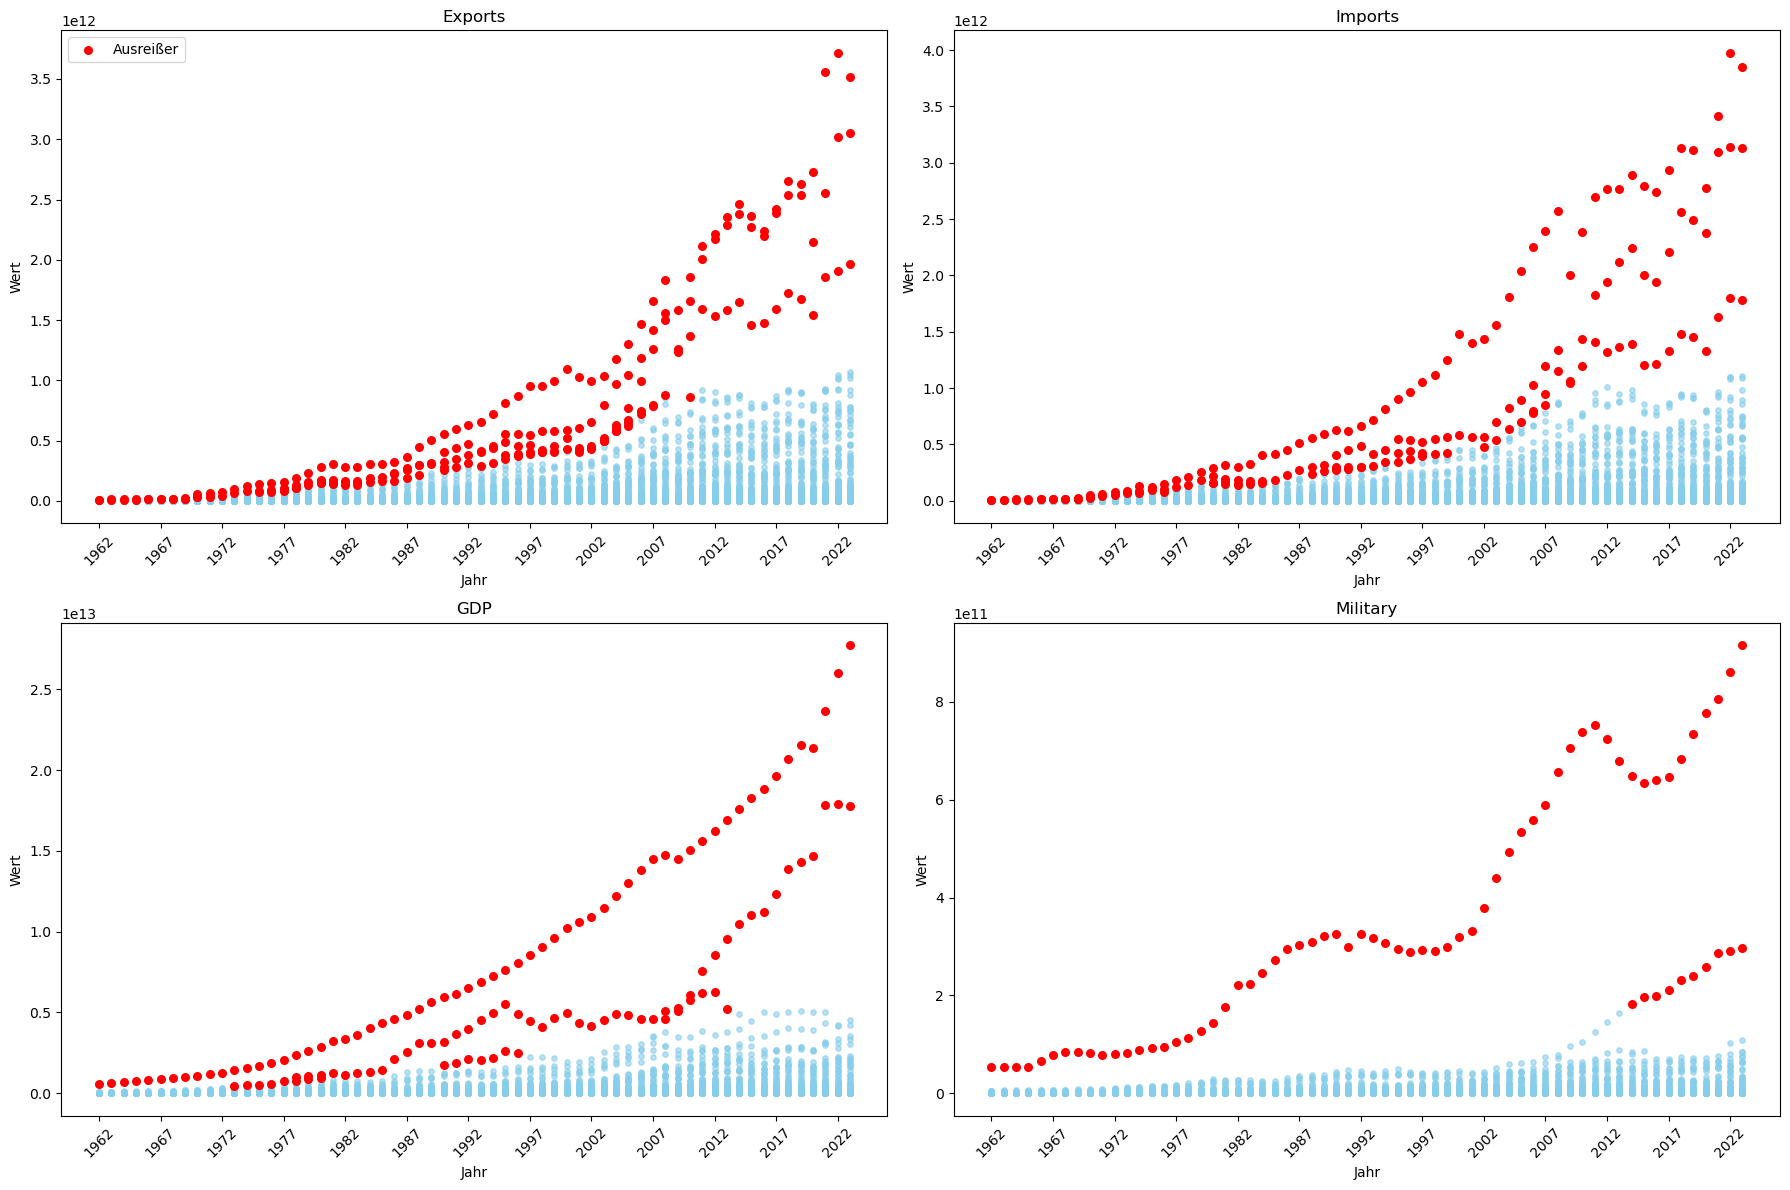

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
dfs = {
	'Exports': (df_export, outliers_exports_z),
	'Imports': (df_import, outliers_imports_z),
	'GDP': (df_gdp, outliers_gdp_z),
	'Military': (df_military, outliers_military_z)
}

for ax, (title, (df, outliers)) in zip(axes.flat, dfs.items()):
	years = df.columns[4:]
	for idx, year in enumerate(years):
		vals = df[year]
		# Normale Werte
		mask = np.ones(len(vals), dtype=bool)
		mask[outliers.get(year, [])] = False
		ax.scatter([idx]*mask.sum(), vals[mask], color='skyblue', alpha=0.6, s=15)
		# Ausreißer
		if outliers.get(year):
			ax.scatter([idx]*len(outliers[year]), vals.iloc[outliers[year]], color='red', s=30, label='Ausreißer' if idx == 0 else "")
	ax.set_title(title)
	ax.set_xlabel('Jahr')
	ax.set_ylabel('Wert')
	ax.set_xticks(range(0, len(years), 5))
	ax.set_xticklabels([years[i] for i in range(0, len(years), 5)], rotation=45)
	if title == 'Exports':
		ax.legend()

plt.tight_layout()
plt.show()